<a href="https://colab.research.google.com/github/dcpatton/keras_tuner/blob/master/keras_tuning_part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import random

seed = 52
tf.random.set_seed(seed)
random.seed(seed)

print('TensorFlow version = ' + tf.__version__)

accuracies = [] # for metric tracking

TensorFlow version = 2.3.0


## Install the Keras Tuner

In [2]:
!pip install keras-tuner -q
import kerastuner as kt
print('Keras Tuner version = ' + kt.__version__)

     |████████████████████████████████| 61kB 1.9MB/s 
Keras Tuner version = 1.0.1


## Load CIFAR10

In [3]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
# Normalize the data
train_images, test_images = train_images / 255.0, test_images / 255.0

170500096/170498071 [==============================] - 16s 0us/step


In [4]:
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

# Baseline

In [5]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras import Input, Model

input1 = Input(shape=(32, 32, 3), name='input1')
x = Conv2D(32, 3, activation='elu')(input1)
x = MaxPool2D()(x)
x = Conv2D(64, 3, activation='elu')(x)
x = MaxPool2D()(x)
x = Conv2D(128, 3, activation='elu')(x)
x = MaxPool2D()(x)
x = Flatten()(x)
out = Dense(10, activation='softmax')(x)

model = Model(inputs=[input1], outputs=[out])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input1 (InputLayer)          [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 128)        

In [6]:
BATCH_SIZE = 128

In [7]:
filepath = 'model.h5'
mc = tf.keras.callbacks.ModelCheckpoint(filepath, save_best_only=True, 
                                        save_weights_only=True)
es = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)

history = model.fit(train_images, train_labels, epochs=200, batch_size=BATCH_SIZE, 
                    validation_data=(test_images, test_labels), 
                    callbacks=[mc, es], verbose=2)

Epoch 1/200
391/391 - 2s - loss: 2.1962 - accuracy: 0.2044 - val_loss: 2.0398 - val_accuracy: 0.2935
Epoch 2/200
391/391 - 2s - loss: 1.9482 - accuracy: 0.3126 - val_loss: 1.8781 - val_accuracy: 0.3381
Epoch 3/200
391/391 - 2s - loss: 1.8207 - accuracy: 0.3580 - val_loss: 1.7761 - val_accuracy: 0.3631
Epoch 4/200
391/391 - 2s - loss: 1.7311 - accuracy: 0.3900 - val_loss: 1.6867 - val_accuracy: 0.4070
Epoch 5/200
391/391 - 2s - loss: 1.6537 - accuracy: 0.4183 - val_loss: 1.6132 - val_accuracy: 0.4269
Epoch 6/200
391/391 - 2s - loss: 1.5871 - accuracy: 0.4422 - val_loss: 1.5526 - val_accuracy: 0.4498
Epoch 7/200
391/391 - 2s - loss: 1.5292 - accuracy: 0.4634 - val_loss: 1.5202 - val_accuracy: 0.4641
Epoch 8/200
391/391 - 2s - loss: 1.4849 - accuracy: 0.4793 - val_loss: 1.5007 - val_accuracy: 0.4679
Epoch 9/200
391/391 - 2s - loss: 1.4413 - accuracy: 0.4952 - val_loss: 1.4336 - val_accuracy: 0.5002
Epoch 10/200
391/391 - 2s - loss: 1.4047 - accuracy: 0.5109 - val_loss: 1.4442 - val_accura

In [8]:
model.load_weights(filepath)
metrics = model.evaluate(test_images, test_labels, verbose=0)
print('Loss = ' + str(metrics[0]))
print('Accuracy = ' + str(metrics[1]))
accuracies.append(metrics[1])

Loss = 0.9419795870780945
Accuracy = 0.6876999735832214


Recall that the Keras tuned DNN achieved:


```
Loss = 1.955668330192566
Accuracy = 0.5008000135421753
```



# Tune SGD parameters

In [9]:
from tensorflow.keras.optimizers import SGD

def build_hypermodel(hp):
  input1 = Input(shape=(32, 32, 3), name='input1')
  x = Conv2D(32, 3, activation='elu')(input1)
  x = MaxPool2D()(x)
  x = Conv2D(64, 3, activation='elu')(x)
  x = MaxPool2D()(x)
  x = Conv2D(128, 3, activation='elu')(x)
  x = MaxPool2D()(x)
  x = Flatten()(x)
  out = Dense(10, activation='softmax')(x)

  model = Model(inputs=[input1], outputs=[out])

  optimizer = SGD(learning_rate=hp.Float(name='lr', min_value=0.005, max_value=0.05, step=0.005),
                  momentum=hp.Float(name='mom', min_value=0.0, max_value=0.9, step=0.1))
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
                metrics=['accuracy'])

  return model

In [10]:
tuner = kt.BayesianOptimization(hypermodel=build_hypermodel,
                        objective='val_loss',
                        max_trials=25,
                        num_initial_points=2,
                        directory='test_dir',
                        project_name='a',
                        seed=seed
                        )

In [11]:
import IPython

class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [12]:
es = tf.keras.callbacks.EarlyStopping(patience=10)
tuner.search(train_images, train_labels, epochs=200, batch_size=BATCH_SIZE, 
             validation_data=(test_images, test_labels), 
             verbose=0, callbacks=[es, ClearTrainingOutput()])

INFO:tensorflow:Oracle triggered exit


In [13]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(f"""
The hyperparameter search is complete. The optimal learning rate is {best_hps.get('lr')}. The optimal momentum is {best_hps.get('mom')}.
""")


The hyperparameter search is complete. The optimal learning rate is 0.049999999999999996. The optimal momentum is 0.0.



In [14]:
model = tuner.hypermodel.build(best_hps)

In [15]:
mc = tf.keras.callbacks.ModelCheckpoint(filepath, save_best_only=True, 
                                        save_weights_only=True)
es = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)

history = model.fit(train_images, train_labels, epochs=200, batch_size=BATCH_SIZE, 
                    validation_data=(test_images, test_labels), 
                    callbacks=[mc, es], verbose=0)

Epoch 00031: early stopping


In [16]:
model.load_weights(filepath)
metrics = model.evaluate(test_images, test_labels, verbose=0)
print('Loss = ' + str(metrics[0]))
print('Accuracy = ' + str(metrics[1]))
accuracies.append(metrics[1])

Loss = 0.9262975454330444
Accuracy = 0.6952000260353088


# Tune optimizer choice

In [17]:
def build_hypermodel(hp):
  input1 = Input(shape=(32, 32, 3), name='input1')
  x = Conv2D(32, 3, activation='elu')(input1)
  x = MaxPool2D()(x)
  x = Conv2D(64, 3, activation='elu')(x)
  x = MaxPool2D()(x)
  x = Conv2D(128, 3, activation='elu')(x)
  x = MaxPool2D()(x)
  x = Flatten()(x)
  out = Dense(10, activation='softmax')(x)

  model = Model(inputs=[input1], outputs=[out])

  optimizer = hp.Choice('opt', values=['Adam', 'SGD', 'RMSprop'])
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
                metrics=['accuracy'])

  return model

In [18]:
tuner = kt.BayesianOptimization(hypermodel=build_hypermodel,
                        objective='val_loss',
                        max_trials=25,
                        num_initial_points=2,
                        directory='test_dir',
                        project_name='b',
                        seed=seed
                        )

In [19]:
es = tf.keras.callbacks.EarlyStopping(patience=10)
tuner.search(train_images, train_labels, epochs=200, batch_size=BATCH_SIZE, 
             validation_data=(test_images, test_labels), 
             verbose=0, callbacks=[es, ClearTrainingOutput()])

INFO:tensorflow:Oracle triggered exit


In [20]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(f"""
The hyperparameter search is complete. The optimal optimizer is {best_hps.get('opt')}.
""")


The hyperparameter search is complete. The optimal optimizer is RMSprop.



In [21]:
model = tuner.hypermodel.build(best_hps)

In [22]:
mc = tf.keras.callbacks.ModelCheckpoint(filepath, save_best_only=True, 
                                        save_weights_only=True)
es = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)

history = model.fit(train_images, train_labels, epochs=200, batch_size=BATCH_SIZE, 
                    validation_data=(test_images, test_labels), 
                    callbacks=[mc, es], verbose=0)

Epoch 00019: early stopping


In [23]:
model.load_weights(filepath)
metrics = model.evaluate(test_images, test_labels, verbose=0)
print('Loss = ' + str(metrics[0]))
print('Accuracy = ' + str(metrics[1]))
accuracies.append(metrics[1])

Loss = 0.9152792096138
Accuracy = 0.6977999806404114


# Tune RMSprop

In [24]:
from tensorflow.keras.optimizers import RMSprop

def build_hypermodel(hp):
  input1 = Input(shape=(32, 32, 3), name='input1')
  x = Conv2D(32, 3, activation='elu')(input1)
  x = MaxPool2D()(x)
  x = Conv2D(64, 3, activation='elu')(x)
  x = MaxPool2D()(x)
  x = Conv2D(128, 3, activation='elu')(x)
  x = MaxPool2D()(x)
  x = Flatten()(x)
  out = Dense(10, activation='softmax')(x)

  model = Model(inputs=[input1], outputs=[out])

  optimizer = RMSprop(learning_rate=hp.Float(name='lr', min_value=0.0005, max_value=0.002, step=0.0005),
                  momentum=hp.Float(name='mom', min_value=0.0, max_value=0.9, step=0.1))
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
                metrics=['accuracy'])

  return model

In [25]:
tuner = kt.BayesianOptimization(hypermodel=build_hypermodel,
                        objective='val_loss',
                        max_trials=25,
                        num_initial_points=2,
                        directory='test_dir',
                        project_name='c',
                        seed=seed
                        )

In [26]:
es = tf.keras.callbacks.EarlyStopping(patience=10)
tuner.search(train_images, train_labels, epochs=200, batch_size=BATCH_SIZE, 
             validation_data=(test_images, test_labels), 
             verbose=0, callbacks=[es, ClearTrainingOutput()])

INFO:tensorflow:Oracle triggered exit


In [27]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(f"""
The hyperparameter search is complete. The optimal learning rate is {best_hps.get('lr')}. The optimal momentum is {best_hps.get('mom')}.
""")


The hyperparameter search is complete. The optimal learning rate is 0.0005. The optimal momentum is 0.0.



In [28]:
model = tuner.hypermodel.build(best_hps)

In [29]:
mc = tf.keras.callbacks.ModelCheckpoint(filepath, save_best_only=True, 
                                        save_weights_only=True)
es = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)

history = model.fit(train_images, train_labels, epochs=200, batch_size=BATCH_SIZE, 
                    validation_data=(test_images, test_labels), 
                    callbacks=[mc, es], verbose=0)

Epoch 00029: early stopping


In [30]:
model.load_weights(filepath)
metrics = model.evaluate(test_images, test_labels, verbose=0)
print('Loss = ' + str(metrics[0]))
print('Accuracy = ' + str(metrics[1]))
accuracies.append(metrics[1])

Loss = 0.9120068550109863
Accuracy = 0.703000009059906


# Results

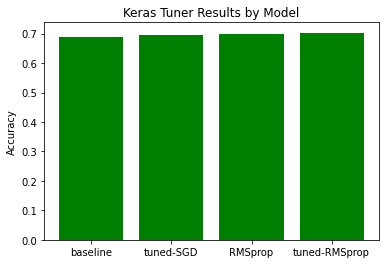

In [31]:
import matplotlib.pyplot as plt

labels = ['baseline', 'tuned-SGD', 'RMSprop', 'tuned-RMSprop']

x_pos = [i for i, _ in enumerate(labels)]

plt.bar(x_pos, accuracies, color='green')
plt.ylabel("Accuracy")
plt.title("Keras Tuner Results by Model")

plt.xticks(x_pos, labels)

plt.show()